In [1]:
# Goal: Investigate the arnett peak using the vanilla variation of it
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
import tqdm
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit
import snelib19odp.analysis.arnett as arnett

In [2]:
%timeit arnett.luminosity_nico(10, 0.2, 10, 3)

5.47 µs ± 25.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
ds = dataset.load_dataset('SN1998bw')

In [4]:
# Params
texpl_range = (ds.first_detection_mjd-4, ds.first_detection_mjd-0.3)
time_range = (ds.first_detection_mjd + 0.3, ds.transient.prior_t0+35)
prior_kwargs = {
#    'vej_min': 9477,
#    'vej_max': 12347,
#    'gamma_trapped': True
}
time_valid = np.array([
    [ds.first_detection_mjd, 51115],
])

../lib/snelib19odp/dataset.py:144: RuntimeWarning: invalid value encountered in multiply
  abs_extinction_mean = extinct_coeff_mean * ebv_mean
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


In [5]:
sampler, _logl = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)

100%|██████████| 12000/12000 [00:31<00:00, 379.13it/s]


In [6]:
sampler.run_nested()#dlogz_init=0.5)
main_results = sampler.results

5260it [09:01,  9.71it/s, +500 | bound: 1094 | nc: 1 | ncall: 1011872 | eff(%):  0.569 | loglstar:   -inf < -2.336 <    inf | logz: -12.299 +/-  0.201 | dlogz:  0.001 >  0.509]


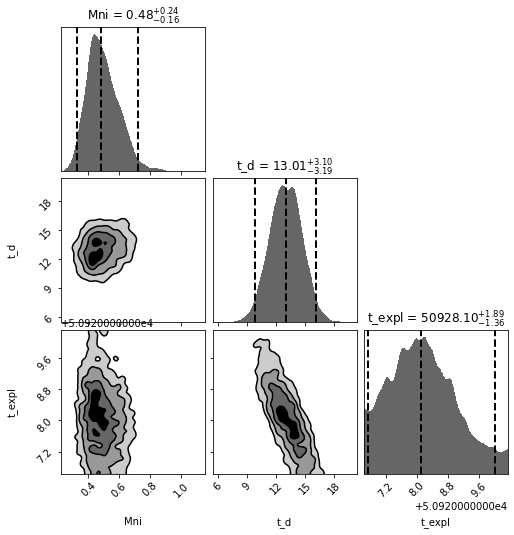

In [7]:
dyplot.cornerplot(sampler.results, labels=['Mni', 't_d', 't_expl'], show_titles=True);

In [8]:
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)

array([11.26392608, 12.71434416])

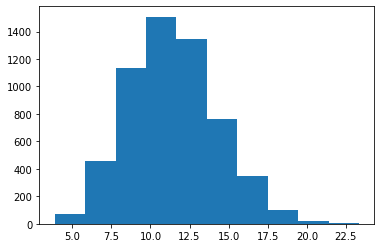

In [9]:
t_d = trace[:,1] * u.day.to(u.s)
xi = np.pi**2 / 3  # Arnett
# xi = 1 # one-zone model
opacity = 0.07
c = aconst.c.cgs.value
v_ej = 30e3 * u.km.to(u.cm)
m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
plt.hist(m_ej);
np.percentile(m_ej, [50, 68])

100%|██████████| 12000/12000 [00:32<00:00, 374.13it/s]
3810it [00:38, 98.83it/s, +500 | bound: 71 | nc: 1 | ncall: 73251 | eff(%):  5.884 | loglstar:   -inf < -0.276 <    inf | logz: -7.177 +/-  0.157 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:32<00:00, 367.70it/s]
4212it [01:02, 67.51it/s, +500 | bound: 121 | nc: 1 | ncall: 116500 | eff(%):  4.045 | loglstar:   -inf < -0.571 <    inf | logz: -8.348 +/-  0.171 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:32<00:00, 374.86it/s]
4289it [01:38, 43.58it/s, +500 | bound: 176 | nc: 1 | ncall: 173868 | eff(%):  2.754 | loglstar:   -inf < -0.831 <    inf | logz: -8.769 +/-  0.175 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:33<00:00, 357.82it/s]
4749it [03:42, 21.35it/s, +500 | bound: 435 | nc: 1 | ncall: 421923 | eff(%):  1.244 | loglstar:   -inf < -1.078 <    inf | logz: -9.998 +/-  0.185 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:31<00:00, 376.49it/s]
5048it [05:47, 14.54it/s, +500 

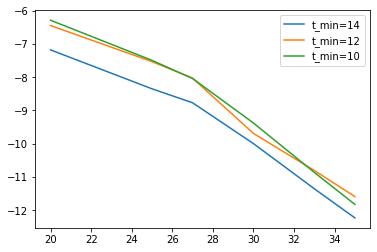

In [10]:
tmins = np.array([14, 12, 10])
tmaxs = np.array([20, 25, 27, 30, 33, 35])
for t_min in tmins:
    results = []
    for t_max in tmaxs:
        while True:
            try:
                time_range = (ds.transient.prior_t0 - t_min, ds.transient.prior_t0+t_max)
                sampler,_logl = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)
                sampler.run_nested()#dlogz_init=0.25)
                break
            except:
                continue
        results.append(sampler.results)
    logz = [result.logz[-1] for result in results]
    plt.plot(tmaxs, logz, label='t_min=%d' % t_min)
plt.legend()

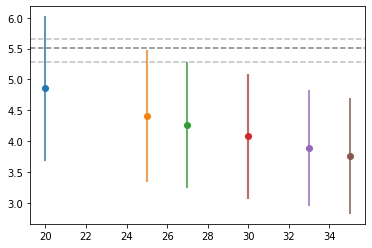

In [11]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    
    t_d = trace[:,1] * u.day.to(u.s)
    xi = np.pi**2 / 3  # Arnett
    # xi = 1 # one-zone model
    opacity = 0.07
    c = aconst.c.cgs.value
    v_ej = 10912 * u.km.to(u.cm)
    m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
    plt.errorbar(t_max, np.nanmean(m_ej), yerr=np.nanstd(m_ej), marker='o')
plt.axhline(5.51, ls='--', color='grey')
plt.axhline(5.51-0.22, ls='--', alpha=0.5, color='grey')
plt.axhline(5.51+0.15, ls='--', alpha=0.5, color='grey');

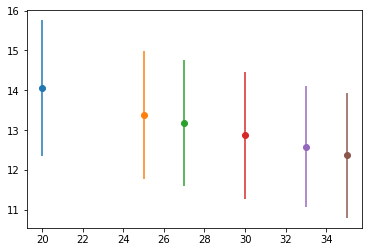

In [12]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    t_d = trace[:,1]
    plt.errorbar(t_max, np.nanmean(t_d), yerr=np.nanstd(t_d), marker='o')

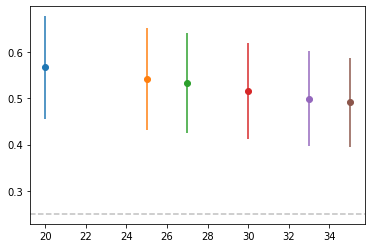

In [13]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    m_ni = trace[:,0]
    plt.errorbar(t_max, np.nanmean(m_ni), yerr=np.nanstd(m_ni), marker='o')
plt.axhline(0.25, ls='--', alpha=0.5, color='grey')

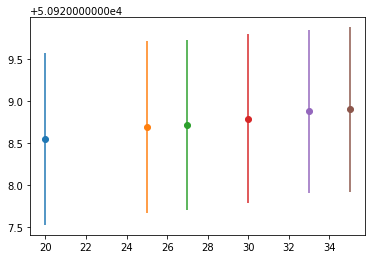

In [14]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    texpl = trace[:,2]
    plt.errorbar(t_max, np.nanmean(texpl), yerr=np.nanstd(texpl), marker='o')

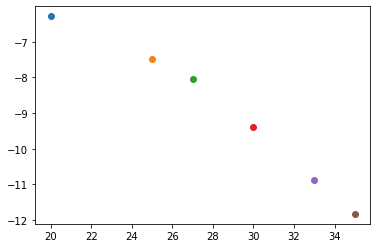

In [15]:
for t_max, result in zip(tmaxs, results):
    logz = result.logz[-1]
    plt.scatter(t_max, logz, marker='o')

In [16]:
texpl_errs = np.array([0.1, 1.0, 2.0, 4.0])
results = []
t_max = 40
for texpl_err in texpl_errs:
    texpl_range = (56458.67 - texpl_err/2, 56458.67+texpl_err/2)
    time_range = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+t_max)
    sampler = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)
    sampler.run_nested()#dlogz_init=0.25)
    results.append(sampler.results)

100%|██████████| 12000/12000 [00:32<00:00, 374.51it/s]
../lib/snelib19odp/analysis/arnett.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = quad(integrand_nico, 0, t, args=(m_ni, td))[0]


AttributeError: 'tuple' object has no attribute 'run_nested'

In [ ]:
for texpl_err, result in zip(texpl_errs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    
    t_d = trace[:,1] * u.day.to(u.s)
    xi = np.pi**2 / 3  # Arnett
    # xi = 1 # one-zone model
    opacity = 0.07
    c = aconst.c.cgs.value
    v_ej = 10912 * u.km.to(u.cm)
    m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
    plt.errorbar(texpl_err, np.nanmean(m_ej), yerr=np.nanstd(m_ej), marker='o')
#plt.axhline(5.51, ls='--', color='grey')

In [ ]:
t_grid = ds.transient.prior_t0 + np.linspace(-16, 50)
bolometric_method = 'lyman'
for i in range(500):
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
    lums = np.log(utils.convert_luminosity(lc))
    #plt.plot(t_grid, lums, alpha=0.02, color='blue')

samples, weights = main_results.samples, np.exp(main_results.logwt - main_results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
modfunc = np.vectorize(arnett.luminosity_nico)
for i in range(500):
    x = trace[i*10 % trace.shape[0]]
    lums = modfunc(t_grid, *x)
    plt.plot(t_grid, lums, alpha=0.02, color='orange')

In [ ]:
t_grid = ds.transient.prior_t0 + np.linspace(-16, 30)
bolometric_method = 'lyman'
for i in range(500):
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
    lums = np.log(utils.convert_luminosity(lc))
    #plt.plot(t_grid, lums - lums[13], alpha=0.02, color='blue')
    plt.plot(t_grid, lums - np.percentile(lums, 95), alpha=0.02, color='blue')

samples, weights = main_results.samples, np.exp(main_results.logwt - main_results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
modfunc = np.vectorize(arnett.luminosity_nico)
for i in range(500):
    x = trace[i*10 % trace.shape[0]]
    #x[2] = 58714.5
    lums = modfunc(t_grid, *x)
    #plt.plot(t_grid, lums - lums[13], alpha=0.02, color='orange')
    plt.plot(t_grid, lums - np.percentile(lums, 95), alpha=0.02, color='orange')